# Molecular dynamics of Argon atoms

(1/3) Weekly tasks:

1) Incorporate **density** and **temperature** into simulation. These are part of the initial conditions. Set up a lattice of 3x3x3 unit cells, where each cells can have 4 particles. The size of the unit cell $a$ determines the density. Use the Maxwell distribution to relate the velocity of the particles to the temperature. **Make sure it's dimensionless!** Now the kinetic energy is $KE=(N-1)\frac{3}{2}k_BT$. The KE & PE will not be stable, so scale the velocity by a factor of $\lambda$ such that $v_i\rightarrow \lambda v_i$, $\lambda = \sqrt{\frac{(N-1)3k_BT}{\sum_i mv_i^2}}$. This is to keep a constant temperature.

2) Observables, including: (1) **pair correlation function** (_15%_). A histogram of the number of particles $n(r)$ at a distance $[r, r+\Delta r]$ for bin size $\Delta r$ which is smaller than $L/2$. The distribution of $N$ particles in a volume $V$ is $g(r)=\frac{2V}{N(N-1)}\frac{\langle n(r)\rangle}{4\pi r^2 \Delta r}$. And (2) the **pressure** (_15%_) or **specific heat** (_If in addition to pressure, up to 10% bonus_). These are given as $\frac{\beta P}{\rho} = 1-\frac{\beta}{3N}\Big\langle \frac{1}{2}\sum_{i,j}\vec{r}_{ij}\frac{\partial U}{\partial \vec {r}_{ij}}\Big\rangle$ where $\beta = \frac{1}{k_BT}$. The specific heat is given as $\frac{\langle \delta K^2\rangle}{\langle K\rangle ^2} = \frac{2}{3N}\Big(1-\frac{3N}{2C_V}\Big)$ where $\langle\delta K^2\rangle = \langle K^2\rangle - \langle K\rangle ^2$, the fluctuation in kinetic energy.

3) Error: For observables, use (block) bootstrap method, with consideration to the correlation of the observables. Given an original set x, create a set of random elements from x(original) where elements can be repeated. This new dataset is 1 bootstrap subset, x$_1^*$. You can take the mean, A$_1^*$, of each bootstrap subset. In total we say we have M number of bootstrap subsets, and M number of means. We take the "mean of the means", $\mu^* = \frac{1}{M}\sum_{i=1}^{M}A_i^*$. The boostrap variance is $s_i^* = A_i^{*2} - \mu^{*2}$. In general, set M=100. Include the standard deviation f the observables as the errorbars for plots.

Things to do towards the end:
- Write up a report
- Polish comments -- get rid of commented code that isn't useful, and only comment "nontrivial" sections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Functions as func

Parameters for states of matter:

Gas: $\rho=0.3$, $T=3$

Liquid: $\rho=0.8$, $T=1$

Solid: $\rho=1.2$, $T=0.5$

In [15]:
phase = 'solid'

# set temperature (T) and density (rho)
if phase == 'gas':
    T = 3.0
    rho = 0.3
elif phase == 'liquid':
    T = 1.0
    rho = 0.8
else:
    T = 1.2
    rho = 0.5    

In [16]:
# Initial conditions
h = 0.004                                          # time step
num_time = int(40.0 / h)                           # number of time steps
num_unit_cells_per_dim = 2                         # number of unit cells in each direction
num_unit_cells = num_unit_cells_per_dim**3         # total number of unit cells
num_part_per_unit_cell = 4                         # number of particles per unit cell
num_part = num_part_per_unit_cell * num_unit_cells # total number of particles
L = np.power(num_part / rho, 1/3.0)                # size of simulation box
K = L / num_unit_cells_per_dim                     # size of unit cell

In [23]:
# state[particle index, time stamp, position :3 or velocity 3:]
state = np.zeros((num_part, num_time, 6))

# store the kinetic and potential energy of each particle for each time step
E_kin = np.zeros((num_part, num_time))
E_pot = np.zeros((num_part, num_time))
E_tot = np.zeros((num_part, num_time))

# save the factor lambda, the forces and distances between particles for each timestep
lambdas = np.zeros(num_time)
forces = np.zeros((num_part, 3))
distances = np.zeros((num_time, num_part, num_part-1))

# the initial velocities of the particles are given by a gaussian ditribution
mu = 1
sigma = np.sqrt(T)
rescaling_time = int(10.0 / h)
rescaling_interval = 10
rescaling_end = int(20.0 / h)

# Initial positions for first unit cell
state[0, 0, :3] = np.array([0.0,     0.0,     0.0])
state[1, 0, :3] = np.array([0.0,     K / 2.0, K / 2.0])
state[2, 0, :3] = np.array([K / 2.0, 0.0,     K / 2.0])
state[3, 0, :3] = np.array([K / 2.0, K / 2.0, 0.0])

# create velocity distribution of e^(-mv^2 / 2k_B * T), where k_B = 1 and m = 1
velocity_distribution = np.random.normal(mu, sigma, num_part)
particle = 0

# set the initial coordinates by placing all particles on a fcc lattice
for x in range(num_unit_cells_per_dim):
    for y in range(num_unit_cells_per_dim):
        for z in range(num_unit_cells_per_dim):
            for p in range(num_part_per_unit_cell):
                state[particle, 0, :3] = state[particle % 4, 0, :3] + np.array([x, y, z]) * K
                state[particle, 0, 3:] = velocity_distribution[particle] * func.create_random_vector()
                particle += 1

# initial lambda factor
lambdas[0] = func.get_lambda(state, 0, num_part, T)

# store initial kinetic, potential and total energy of each particle and the system
for p in range(num_part):
    F, P, _ = func.get_force(state, 0, p, L)
    E_kin[p, 0] = func.norm(func.KE(state[p, 0, 3:]))
    E_pot[p, 0] = 0.5 * P
    E_tot[p, 0] = E_pot[p, 0] + E_kin[p, 0]    

In [24]:
for t in range(1, num_time):    
    # rescale at intervals in a certain range of timesteps
    if t >= rescaling_time and t < rescaling_end and (t - rescaling_time) % rescaling_interval == 0:
        lambda_factor = np.average(lambdas[t-1-rescaling_interval:t-1])
        state[:, t-1, 3:] = lambda_factor * state[:, t-1, 3:]
        
    for p in range(num_part):
        # the distance and force between the two closest particles at t-1
        forces[p], _, _ = func.get_force(state, t-1, p, L)

        # positions at time t
        state[p, t, :3] = func.next_position(state[p, t-1, :3], state[p, t-1, 3:], forces[p], h, L)

    for p in range(num_part):
        F_next, P_next, distances[t, p, :] = func.get_force(state, t, p, L)
        v_next = func.next_velocity(state[p, t-1, 3:], forces[p], F_next, h)
        state[p, t, 3:] = v_next

        # calculate the energy of the particle
        E_kin[p, t] = func.norm(func.KE(v_next))
        E_pot[p, t] = 0.5 * P_next
        E_tot[p, t] = E_pot[p, t] + E_kin[p, t]
        lambdas[t] = func.get_lambda(state, t, num_part, T)

For pair correlation function: Count the number of particles at a given distance within a bin size (have the bin size variable). Take the average of this count over all time steps. This will be "_n(r)_"

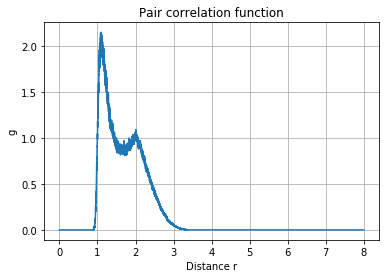

In [25]:
data = np.average(distances[rescaling_end:, :, :], axis=0)
data = distances[rescaling_end:, :, :]
dr = 0.001
r_min = 0.0
r_max = L * 2.0 if np.max(data) < L * 2.0 else np.max(data)
bins = np.arange(r_min, r_max, dr)
centers = np.linspace(bins[0] + dr / 2.0, bins[-1] - dr / 2.0, len(bins) - 1)
hist, _ = np.histogram(data, bins)
pair_correlation = func.pair_correlation(hist, centers, dr, L, num_part) / num_time

plt.figure()
plt.title('Pair correlation function')
plt.plot(centers, pair_correlation)
plt.xlabel('Distance r')
plt.ylabel('g')
plt.grid()
plt.savefig('output/{}/pair_correlation_function.png'.format(phase))

# plt.figure()
# plt.plot(centers, hist)
# plt.xlim(0.0, L * 2.0)
# plt.xlabel('Distance r')
# plt.ylabel('Frequency')
# plt.grid()

plt.show()

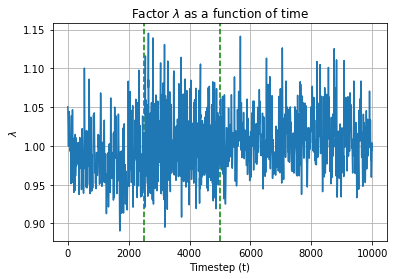

Average lambda till t=2500: 0.983
Average lambda from t=5000: 1.008


In [26]:
plt.figure()
plt.title('Factor $\lambda$ as a function of time')
plt.axvline(rescaling_time, color='g', ls='--')
plt.axvline(rescaling_end, color='g', ls='--')
plt.plot(range(num_time), lambdas)
plt.xlabel('Timestep (t)')
plt.ylabel('$\lambda$')
plt.grid()
plt.savefig('output/{}/lambda.png'.format(phase))
plt.show()

print('Average lambda till t={}: {:.3f}'.format(rescaling_time, np.average(lambdas[:rescaling_time])))
print('Average lambda from t={}: {:.3f}'.format(rescaling_end, np.average(lambdas[rescaling_end:])))

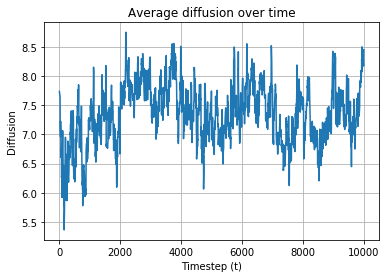

In [27]:
state_copy = state.copy()
for p in range(num_part):
    state_copy[p, :, :3] = state_copy[p, :, :3] - state_copy[p, 0, :3]
    
diffusion = np.average(func.norm(state_copy ** 2.0, axis=2), axis=0)

plt.figure()
plt.title('Average diffusion over time')
plt.plot(range(1, num_time), diffusion[1:])
plt.xlabel('Timestep (t)')
plt.ylabel('Diffusion')
plt.grid()
plt.savefig('output/{}/diffusion.png'.format(phase))
plt.show()

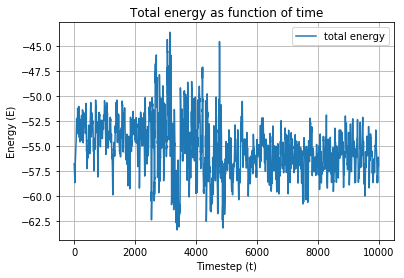

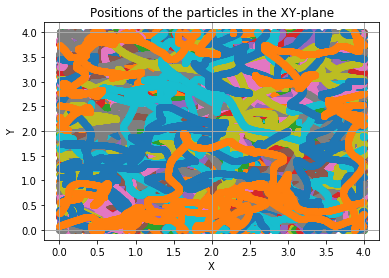

In [28]:
# plot the potential, kinetic and total energy
plt.title('Total energy as function of time')
# plt.plot(range(num_time), np.sum(E_kin[:, :], axis=0), label='kinetic energy')
# plt.plot(range(num_time), np.sum(E_pot[:, :], axis=0), label='potential energy')    
plt.plot(range(num_time), np.sum(E_tot[:, :], axis=0), label='total energy')
plt.xlabel('Timestep (t)')
plt.ylabel('Energy (E)')
plt.grid()
plt.legend()
plt.savefig('output/{}/total_energy.png'.format(phase))

# plot the positions of all particles in a new figure and plot the initial positions in green
plt.figure()
plt.title('Positions of the particles in the XY-plane')
for p in range(num_part):
    plt.scatter(state[p, 1:, 0], state[p, 1:, 1], label='particle {}'.format(x))

# restrict the view around the box + a small margin
view_margin = K / 10.0
plt.xlim(-view_margin, K * num_unit_cells_per_dim + view_margin)
plt.ylim(-view_margin, K * num_unit_cells_per_dim + view_margin)
plt.xlabel('X')
plt.ylabel('Y')

# add border lines around the box
for x in range(num_unit_cells_per_dim + 1):
    for y in range(num_unit_cells_per_dim + 1):
        plt.axvline(x * K, c='darkgrey', lw = 1)
        plt.axhline(y * K, c='darkgrey', lw = 1)

plt.savefig('output/{}/positions.png'.format(phase))
plt.show()